# Customer Segmentation Report

Customer segmentation is a way to identify groups of similar customers. Customers can be segmented on a wide variety of characteristics, such as demographic information, purchase behavior, and attitudes. This template provides an end-to-end report for processing and segmenting customer purchase data using a K-means clustering algorithm. It also includes a snake plot and heatmap to visualize the resulting clusters and feature importance.

## Step 1: Loading packages and Inspecting the Data
The code below imports the packages necessary for data manipulation, visualization, pre-processing, and clustering. It also sets up the visualization style and loads in the data. Finally, it inspects the data types and missing values with the .info() method from pandas.

In [1695]:
pip install pyppeteer

Note: you may need to restart the kernel to use updated packages.


In [1696]:
pip install nbconvert

In [1697]:
!pip install --user --upgrade matplotlib

In [1698]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

df = pd.read_csv('US_Ecommerce_records_2020.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3312 entries, 0 to 3311
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Order Date    3312 non-null   object 
 1   Row ID        3312 non-null   int64  
 2   Order ID      3312 non-null   object 
 3   Ship Mode     3312 non-null   object 
 4   Customer ID   3312 non-null   object 
 5   Segment       3312 non-null   object 
 6   Country       3312 non-null   object 
 7   City          3312 non-null   object 
 8   State         3312 non-null   object 
 9   Postal Code   3312 non-null   int64  
 10  Region        3312 non-null   object 
 11  Product ID    3312 non-null   object 
 12  Category      3312 non-null   object 
 13  Sub-Category  3312 non-null   object 
 14  Product Name  3312 non-null   object 
 15  Sales         3312 non-null   float64
 16  Quantity      3312 non-null   int64  
 17  Discount      3312 non-null   float64
 18  Profit        3312 non-null 

## Step 2: Calculate RFM Quartiles

### Recency Quartiles (q=4)

#### 1. Convert 'Order_Date' to Datetime Format
To ensure the data is in a suitable format for date-related calculations, we first convert the Order Date column to a datetime object. This is important for calculating the number of days between each order and the most recent order. We use pd.to_datetime() with a mixed format to handle potential variations in date format within the dataset. Checking the data types using print(df.dtypes) ensures the conversion is successful.

In [1702]:
# Convert the 'Order_Date' column to datetime format if it's not already
df['Order_Date'] = pd.to_datetime(df['Order Date'], format='mixed')
print(df.dtypes)

Order Date              object
Row ID                   int64
Order ID                object
Ship Mode               object
Customer ID             object
Segment                 object
Country                 object
City                    object
State                   object
Postal Code              int64
Region                  object
Product ID              object
Category                object
Sub-Category            object
Product Name            object
Sales                  float64
Quantity                 int64
Discount               float64
Profit                 float64
Order_Date      datetime64[ns]
dtype: object


#### 2. Calculate Recency in Days
Recency refers to how recently a customer made a purchase, which is critical for customer segmentation. Here, we calculate the Recency as the difference between the latest order date in the dataset (latest_date) and each individual customer’s order date. This results in a Recency_Days column, where smaller values indicate more recent purchases.

In [1704]:
# Find the latest order date in the dataset
latest_date = df['Order_Date'].max()

# Calculate recency as the number of days since the most recent order date
df['Recency_Days'] = (latest_date - df['Order_Date']).dt.days

#### 3. Define, Sort and Review Recency Quartiles
We divide customers into quartiles (four equal parts) based on their recency scores. The pd.qcut() function automatically bins the Recency_Days values into four quartiles, labeled from 4 (least recent) to 1 (most recent). These labels represent the customer’s recency score, where:

* R = 1 means the customer purchased most recently.
* R = 4 means the customer hasn't purchased for a longer time.

Finally, we sort the DataFrame by the R values to review how customers have been segmented into the four quartiles. This step helps verify that the quartiling logic has been applied correctly and that the recency values have been categorized as expected.

In [1706]:
# Store labels from 4 to 1 in a decreasing order
r_labels = list(range(4, 0, -1))

# Create recency quartiles with 4 groups
recency_quartiles = pd.qcut(df['Recency_Days'], q=4, labels=r_labels)

# Assign the quartile values to the 'Recency_Quartile' column
df['R'] = recency_quartiles

# Print the DataFrame sorted by 'Recency_Days'
print(df.sort_values('R'))

     Order Date  Row ID        Order ID       Ship Mode Customer ID  \
3311   30-12-20    5092  CA-2017-156720  Standard Class    JM-15580   
2746   23-11-20    4775  CA-2017-119746  Standard Class    CM-12385   
2745   23-11-20    4774  CA-2017-119746  Standard Class    CM-12385   
2744   23-11-20    4773  CA-2017-119746  Standard Class    CM-12385   
2743   23-11-20    3554  CA-2017-107832    Second Class    FH-14275   
...         ...     ...             ...             ...         ...   
960    2/6/2020    4769  CA-2017-158883        Same Day    CS-11860   
959    2/6/2020    3690  CA-2017-140760    Second Class    DO-13435   
958    2/6/2020    3689  CA-2017-140760    Second Class    DO-13435   
967    3/6/2020    6476  CA-2017-140872  Standard Class    NR-18550   
1655   2/9/2020    1955  CA-2017-157987  Standard Class    AC-10615   

        Segment        Country            City           State  Postal Code  \
3311   Consumer  United States        Loveland        Colorado      

### Frequency Quartiles (q=4)

#### 1. Calculate Frequency of Purchases
Frequency refers to how often a customer makes purchases. In this step, we calculate the Frequency by grouping the dataset by Customer ID and counting how many times each customer has made a purchase. The transform('count') function ensures that this frequency is calculated for each customer across all their orders and adds this as a new column, Frequency, in the DataFrame.

#### 2. Define, Sort and Review Frequency Quartiles
Next, we divide customers into quartiles (four equal groups) based on their purchase frequency. Similar to recency quartiles, we use pd.qcut() to break the customers' frequency data into four groups, with labels from 1 to 4. In this case:

* F = 1 means the customer has the lowest frequency (fewest purchases),
* F = 4 means the customer has the highest frequency (most frequent purchases).

The new quartile labels are stored in a column named F, representing each customer's frequency score within the RFM framework.

Finally, to verify the frequency quartiles are correctly applied, we sort the DataFrame by the F column. This helps ensure that the customers are categorized according to their purchasing frequency and allows you to check if the F scores match the expected frequency behavior.

In [1709]:
# Group the data by 'CustomerID' and count the number of occurrences (i.e., frequency of purchases)
df['Frequency'] = df.groupby('Customer ID')['Order ID'].transform('count')

# Create frequency quartiles with 4 groups
frequency_quartiles = pd.qcut(df['Frequency'], q=4, labels=range(1, 5))

# Assign the quartile values to the 'Frequency_Quartile' column
df['F'] = frequency_quartiles

# Print the DataFrame sorted by 'Recency_Days'
print(df.sort_values('F'))

     Order Date  Row ID        Order ID       Ship Mode Customer ID  \
3311   30-12-20    5092  CA-2017-156720  Standard Class    JM-15580   
804    14-05-20    1245  CA-2017-133641  Standard Class    EJ-14155   
805    14-05-20    4161  CA-2017-115546  Standard Class    AH-10465   
806    14-05-20    4162  CA-2017-115546  Standard Class    AH-10465   
807    14-05-20    4649  CA-2017-129357  Standard Class    KB-16585   
...         ...     ...             ...             ...         ...   
1906   17-09-20    7452  CA-2017-105669    Second Class    SJ-20125   
1907   17-09-20    7453  CA-2017-105669    Second Class    SJ-20125   
1910   17-09-20    9726  CA-2017-142293     First Class    SC-20380   
1842   14-09-20    6812  CA-2017-156237     First Class    PS-18760   
1655   2/9/2020    1955  CA-2017-157987  Standard Class    AC-10615   

          Segment        Country           City         State  Postal Code  \
3311     Consumer  United States       Loveland      Colorado        

### Spend Quartiles (q=4)


#### 1. Calculate Total Spend per Customer
Monetary value (M) represents the total amount each customer has spent. In this step, we group the dataset by Customer ID and calculate the sum of all the sales made by each customer. This gives us the total spend for each customer, stored in a DataFrame called sales_per_customer. The .reset_index() ensures that the grouped data is returned as a new DataFrame with Customer ID and the corresponding sum of Sales.

#### 2. Sort Customers by Spend
We sort the customers in descending order of their total spend, allowing us to review the customers who have spent the most and confirm the calculations. This step ensures that we correctly computed the sum of sales for each customer before proceeding to quartile assignment.

In [1712]:
# Group by 'CustomerID' and sum the 'Sales' for each customer
sales_per_customer = df.groupby('Customer ID')['Sales'].sum().reset_index()

sales_per_customer_sorted = sales_per_customer.sort_values(by='Sales', ascending=False)

# Review the result
print(sales_per_customer_sorted)

    Customer ID      Sales
543    RB-19360  14203.278
636    TA-21385  13723.498
291    HL-15040  10522.550
627    SV-20365   8459.936
275    GT-14635   8167.420
..          ...        ...
676    TZ-21580      5.160
347    JM-15580      3.024
644    TB-21595      2.910
664    TS-21085      2.808
513    PC-18745      1.188

[693 rows x 2 columns]


#### 3. Define Spend Quartiles
Next, we divide customers into Monetary (spend) quartiles using pd.qcut(). This divides the total sales into four groups, with labels from 1 to 4.

* M = 1 indicates that the customer spent the least,
* M = 4 indicates that the customer spent the most.

We assign the quartile labels to the M column, which represents the monetary score for each customer.

#### 4. Sort and Review Spend Values
To verify the correct application of spend quartiles, we sort the DataFrame by Sales. This shows customers' total spend values, and we can check if the M score matches the spend ranges we expect.

In [1714]:
# Create a spend quartile with 4 groups - a range between 1 and 5
spend_quartile = pd.qcut(df['Sales'], q=4, labels=range(1,5))

# Assign the quartile values to the Spend_Quartile column in data
df['M'] = spend_quartile

# Print data with sorted Spend values
print(df.sort_values('Sales'))

      Order Date  Row ID        Order ID       Ship Mode Customer ID  \
1096    19-06-20    4102  US-2017-102288  Standard Class    ZC-21910   
272     2/3/2020    9293  CA-2017-124114        Same Day    RS-19765   
2201  12/10/2020    2762  CA-2017-126536     First Class    NK-18490   
1253    9/7/2020     977  US-2017-100209  Standard Class    TD-20995   
654     24-04-20    1686  CA-2017-149489     First Class    DK-12835   
...          ...     ...             ...             ...         ...   
66      16-01-20    6521  CA-2017-138289    Second Class    AR-10540   
2443   4/11/2020     684  US-2017-168116        Same Day    GT-14635   
2644    17-11-20    4191  CA-2017-166709  Standard Class    HL-15040   
2302    22-10-20    2624  CA-2017-127180     First Class    TA-21385   
427     23-03-20    8154  CA-2017-140151     First Class    RB-19360   

          Segment        Country           City           State  Postal Code  \
1096     Consumer  United States        Houston        

#### 5. Duplicate the "Sales" Column as "Monetary_Value'
For consistency in naming, we duplicate the Sales column and rename it to Monetary_Value. This will help maintain clarity, especially when analyzing or presenting the RFM segmentation later. The Monetary_Value column now stores the total amount spent by each customer, which will be used for further analysis or reporting.

In [1716]:
# Duplicate the 'Sales' column and rename it to 'Monetary_Value'
df['Monetary_Value'] = df['Sales']

# Print the DataFrame to verify the new column
print(df.head())

  Order Date  Row ID        Order ID       Ship Mode Customer ID      Segment  \
0   1/1/2020     849  CA-2017-107503  Standard Class    GA-14725     Consumer   
1   1/1/2020    4010  CA-2017-144463  Standard Class    SC-20725     Consumer   
2   1/1/2020    6683  CA-2017-154466     First Class    DP-13390  Home Office   
3   1/1/2020    8070  CA-2017-151750  Standard Class    JM-15250     Consumer   
4   1/1/2020    8071  CA-2017-151750  Standard Class    JM-15250     Consumer   

         Country         City       State  Postal Code  ... Quantity Discount  \
0  United States       Lorain        Ohio        44052  ...        4      0.2   
1  United States  Los Angeles  California        90036  ...       11      0.0   
2  United States     Franklin   Wisconsin        53132  ...        2      0.0   
3  United States   Huntsville       Texas        77340  ...        5      0.2   
4  United States   Huntsville       Texas        77340  ...        5      0.6   

     Profit Order_Date Rec

## Step 3: Creating RFM Dataframe
Now that we have calculated the Recency, Frequency, and Monetary (RFM) values, the next step is to create a new DataFrame that will hold these essential metrics for each customer.

The code below selects only the relevant columns (Customer ID, Recency_Days, Frequency, Monetary_Value, and their corresponding quartiles R, F, M) and creates a new DataFrame named new_df.

This new DataFrame is critical for further analysis, as it consolidates the core RFM data, making it easier to perform segmentation and clustering.

In [1718]:
# Select the desired columns and create a new DataFrame
new_df = df[['Customer ID', 'Recency_Days', 'Frequency', 'Monetary_Value', 'R', 'F', 'M']]

# Print the new DataFrame to verify
print(new_df.head())

  Customer ID  Recency_Days  Frequency  Monetary_Value  R  F  M
0    GA-14725           364         11          48.896  1  4  2
1    SC-20725           364          5         474.430  1  2  4
2    DP-13390           364          2           3.600  1  1  1
3    JM-15250           364         15         454.560  1  4  4
4    JM-15250           364         15         141.420  1  4  3


### Building RFM segments and RFM score
In this step, we create RFM segments to group customers based on their Recency (R), Frequency (F), and Monetary (M) behaviors. By using a custom function, join_rfm(x), and applying it to the RFM values, we concatenate these metrics into a string, resulting in a segment code that provides a snapshot of each customer's transactional behavior. Additionally, we calculate the RFM score by summing the individual R, F, and M values, giving us a numeric ranking to easily compare customers.

The reason for using .copy() is to avoid the SettingWithCopyWarning in pandas, which occurs when modifications are made to a slice or view of a DataFrame. Without explicitly copying the DataFrame, any modifications (like adding columns) may inadvertently affect the original DataFrame or lead to unpredictable behavior. By making a copy, we ensure that we are safely working on a separate, independent DataFrame.

In [1720]:
# Function to create RFM_Segment by concatenating R, F, and M values as strings
def join_rfm(x): 
    return str(x['R']) + str(x['F']) + str(x['M'])

# Apply the function to create the RFM_Segment
new_df_copy.loc[:, 'RFM_Segment'] = new_df_copy.apply(join_rfm, axis=1)

# Calculate the RFM_Score as the sum of R, F, and M
new_df_copy.loc[:, 'RFM_Score'] = new_df_copy[['R', 'F', 'M']].sum(axis=1)

# Preview the updated DataFrame
print(new_df_copy.head())

  Customer ID  Recency_Days  Frequency  Monetary_Value  R  F  M RFM_Segment  \
0    GA-14725           364         11          48.896  1  4  2         142   
1    SC-20725           364          5         474.430  1  2  4         124   
2    DP-13390           364          2           3.600  1  1  1         111   
3    JM-15250           364         15         454.560  1  4  4         144   
4    JM-15250           364         15         141.420  1  4  3         143   

   RFM_Score  
0          7  
1          7  
2          3  
3          9  
4          8  


### Handling Duplicate Customer IDs
In this step, we identify and remove duplicate customer IDs from the dataset to ensure accuracy in our customer segmentation analysis. Duplicates can distort insights, particularly when calculating metrics such as total purchases, recency, and customer value. The process involves detecting duplicates, aggregating data to consolidate information for each unique customer, and recalculating the RFM Segment and RFM Score after the cleaning process.

#### 1. Identifying Duplicate Customer IDs
First, we check for duplicate Customer ID values in the dataset. Since each Customer ID should represent a unique customer, we need to flag any IDs that appear more than once.

In [1722]:
# Count of duplicates for each Customer ID
duplicate_counts = new_df_copy['Customer ID'].value_counts()
duplicates_only = duplicate_counts[duplicate_counts > 1]
print(duplicates_only)

Customer ID
SV-20365    20
JL-15835    20
MH-18115    19
Dp-13240    19
LC-16870    17
            ..
BN-11470     2
TP-21565     2
MT-17815     2
GB-14530     2
KB-16315     2
Name: count, Length: 597, dtype: int64


#### 2. Removing Duplicate Customer IDs
Next, we use groupby to consolidate the data for customers with duplicate IDs, applying aggregation functions to merge the data meaningfully. Each Customer ID is kept unique, and the relevant columns are aggregated based on specific rules.

**Final Data Cleaning**

To ensure no future issues with log transformations, we increment the Recency_Days column by 1 (to avoid zeros).

**Recalculating RFM Segment and Score**

With the cleaned data, we recalculate the RFM_Segment and RFM_Score based on the aggregated values.

In [1724]:
new_df_cleaned = new_df_copy.groupby('Customer ID').agg({
    'Recency_Days': 'min',  # Typically, you want to keep the most recent activity (smallest Recency_Days)
    'Frequency': 'sum',  # Aggregating by sum captures total engagement. This is valid if you want to know the overall number of purchases.
    'Monetary_Value': 'sum',  # Summing total purchases is a common approach, ensuring you capture the total value attributed to the customer.
    'R': 'min',  # Taking the minimum recency captures the most recent activity.
    'F': 'max', # Summing frequency is logical if your aim is to understand total purchases.
    'M': 'max',  # Summing monetary values is standard for capturing customer spend.
}).reset_index()

# Add 1 to the 'Recency_Days' column (to avoid future issues with log transformation later)
new_df_cleaned['Recency_Days'] = new_df_cleaned['Recency_Days'] + 1

# Recalculate RFM Segment and Score
new_df_cleaned['RFM_Segment'] = new_df_cleaned['R'].astype(str) + new_df_cleaned['F'].astype(str) + new_df_cleaned['M'].astype(str)
new_df_cleaned['RFM_Score'] = new_df_cleaned[['R', 'F', 'M']].sum(axis=1)

print(new_df_cleaned)

    Customer ID  Recency_Days  Frequency  Monetary_Value  R  F  M RFM_Segment  \
0      AA-10315           185          4         374.480  2  1  4         214   
1      AA-10375            49         25         206.732  2  2  3         223   
2      AA-10480           260          1          15.552  2  1  1         211   
3      AA-10645           234          1          12.960  2  1  1         211   
4      AB-10060           106         64        2936.264  2  3  4         234   
..          ...           ...        ...             ... .. .. ..         ...   
688    XP-21865            44         36         449.312  2  2  3         223   
689    YC-21895             5          1         750.680  4  1  4         414   
690    YS-21880            10         49        5340.264  1  3  4         134   
691    ZC-21910            55         64         227.066  2  3  3         233   
692    ZD-21925            55          1          61.440  4  1  3         413   

     RFM_Score  
0         

#### 3. Verifying Duplicate Removal
Finally, we verify that no duplicates remain by checking the count of each Customer ID again.

In [1726]:
# Count of duplicates for each Customer ID
dup_counts = new_df_cleaned['Customer ID'].value_counts()
dup_only = dup_counts[duplicate_counts > 1]
print(dup_only)

Customer ID
AA-10315    1
MO-17800    1
ML-18040    1
ML-18265    1
MM-17260    1
           ..
EH-13945    1
EH-14005    1
EH-14125    1
EJ-13720    1
EJ-14155    1
Name: count, Length: 597, dtype: int64


### Exploring the Data
This part of the analysis focuses on exploring, validating, and summarizing the data after handling duplicates. Here's why each section of the code is important and how it helps to validate the deduplication process:
#### 1. Analyzing the RFM Table
This line groups the customers by their RFM_Segment (a combination of their recency, frequency, and monetary values) and lists the top 10 most common segments in descending order. This helps in understanding the distribution of customers across different behavioral segments.

In [1728]:
new_df_cleaned.groupby('RFM_Segment').size().sort_values(ascending=False)[:10]

RFM_Segment
114    67
134    66
124    63
214    59
144    36
224    34
314    33
213    26
234    26
112    25
dtype: int64

#### 2. Filtering RFM Segments Pre- and Post-Deduplication
Below, you're examining a specific customer ID, SV-20365, in both the pre-deduplication and post-deduplication datasets. This is crucial for validating that the deduplication process worked as intended.

**Before Duplication**

This piece shows the multiple entries for customer ID SV-20365 before handling duplicates. You can see that this customer appears several times with varying Monetary_Value, but the same Frequency and Recency_Days values.

In [1730]:
new_df_copy[new_df_copy['Customer ID']=='SV-20365']

,Customer ID,Recency_Days,Frequency,Monetary_Value,R,F,M,RFM_Segment,RFM_Score
1317,SV-20365,165,20,599.970,2,4,4,244,10
1318,SV-20365,165,20,198.744,2,4,3,243,9
1319,SV-20365,165,20,9.184,2,4,1,241,7
1437,SV-20365,205,20,145.740,2,4,3,243,9
1438,SV-20365,205,20,15.400,2,4,1,241,7
1587,SV-20365,127,20,130.980,3,4,3,343,10
1946,SV-20365,101,20,272.646,3,4,4,344,11
1947,SV-20365,101,20,212.800,3,4,4,344,11
1948,SV-20365,101,20,38.520,3,4,2,342,9
1949,SV-20365,101,20,72.640,3,4,3,343,10


**After Duplication**

After deduplication, the data for SV-20365 is consolidated, as evidenced by the RFM_Segment '244'. Now, this customer appears only once in the cleaned dataset, with an aggregated Monetary_Value and a recalculated RFM_Score.

In [1732]:
new_df_cleaned[new_df_cleaned['RFM_Segment']=='244'][:10]

,Customer ID,Recency_Days,Frequency,Monetary_Value,R,F,M,RFM_Segment,RFM_Score
25,AH-10075,35,144,1921.0010,2,4,4,244,10
154,CS-12355,7,121,1569.4620,2,4,4,244,10
155,CS-12400,3,100,2298.2905,2,4,4,244,10
182,DK-12835,71,144,1669.7300,2,4,4,244,10
203,DR-12880,4,225,4131.5220,2,4,4,244,10
276,GT-14710,37,100,1196.8520,2,4,4,244,10
342,JL-15505,50,100,2638.9500,2,4,4,244,10
531,PS-18760,108,144,1079.9590,2,4,4,244,10
617,SP-20620,48,144,3136.6670,2,4,4,244,10
627,SV-20365,102,400,8459.9360,2,4,4,244,10


#### 3. Summary metrics per RFM scrore
This section summarizes key metrics (average Recency_Days, Frequency, and Monetary_Value) for each RFM_Score. It also counts how many customers fall into each score category. It provides a holistic view of customer distribution across different RFM scores, which can guide marketing and customer retention strategies. By aggregating these metrics, you gain insights into the behavior of customers with different levels of engagement and spending.

In [1734]:
new_df_cleaned.groupby('RFM_Score').agg({
    'Recency_Days': 'mean',
    'Frequency': 'mean',
    'Monetary_Value': ['mean', 'count']
}).round(1)

Recency_Days Frequency Monetary_Value      
                  mean      mean           mean count
RFM_Score                                            
3                269.8       2.8           15.9    12
4                179.0       6.0           44.7    32
5                168.6       5.4          109.1    45
6                142.1      10.6          726.0   134
7                109.5      19.3          987.4   172
8                 76.2      38.8         1295.8   157
9                 48.8      80.5         1755.5   113
10                44.0      96.3         2016.8    25
11                29.0     108.3         2446.2     3

## Step 4. Data Preprocessing for Clustering

### Columns for k-means Clustering
In this step, we prepare the dataset for clustering using the K-means algorithm. Clustering requires a selection of relevant features that capture the essential characteristics of the data, so we specifically choose the following columns:

* Recency_Days: Represents the number of days since the customer's last purchase.
* Frequency: Indicates the total number of purchases made by the customer.
* Monetary_Value: Represents the total monetary value spent by the customer.

By creating a new DataFrame called new_df_metrics, we isolate these three features for clustering analysis.

We also generate a summary of descriptive statistics for these columns using the .describe() method. This summary provides key insights, including the count, mean, standard deviation, minimum, and maximum values, as well as the quartiles.

This step ensures that we have a clear understanding of the distribution of our clustering variables, which is crucial for the K-means algorithm to function effectively. Understanding these statistics can help in determining the scaling methods needed to normalize the data before applying clustering techniques.

In [1737]:
# Select columns for clustering
columns_for_clustering = ["Recency_Days", "Frequency", "Monetary_Value"]

# Create new DataFrame with clustering variables
new_df_metrics = new_df_cleaned[columns_for_clustering]

# Print a summary of descriptive statistics
new_df_metrics.describe()

,Recency_Days,Frequency,Monetary_Value
count,693.000000,693.000000,693.000000
mean,105.477633,33.370851,1058.030671
std,92.508732,48.182092,1463.910713
min,1.000000,1.000000,1.188000
25%,35.000000,4.000000,204.405000
50%,76.000000,16.000000,604.910000
75%,159.000000,36.000000,1334.641600
max,362.000000,400.000000,14203.278000


### Exploring with Histograms
In this step, we utilize the FacetGrid function from Seaborn to create a grid of histograms for the selected clustering variables: Recency_Days, Frequency, and Monetary_Value. This visual exploration helps us assess the distribution of each variable and identify any skewness in the data.

By melting the new_df_metrics DataFrame, we reformat it into a long format, which facilitates plotting with FacetGrid. The col parameter specifies that we want to create separate plots for each variable, allowing for an easy visual comparison across different features. We also disable shared axes (sharey=False and sharex=False) to ensure that each histogram is scaled independently, providing a clearer view of each distribution.

The histograms reveal important characteristics of the data, such as whether the distributions are normal or skewed. This insight is critical for deciding if any transformations (e.g., log transformation) are necessary before proceeding with clustering. Finally, we adjust the layout to accommodate the title and display the plot, labeling it "Unprocessed Variable Distributions" for clarity.

This exploratory analysis is essential for understanding the nature of the data and making informed decisions regarding preprocessing steps before applying K-means clustering.

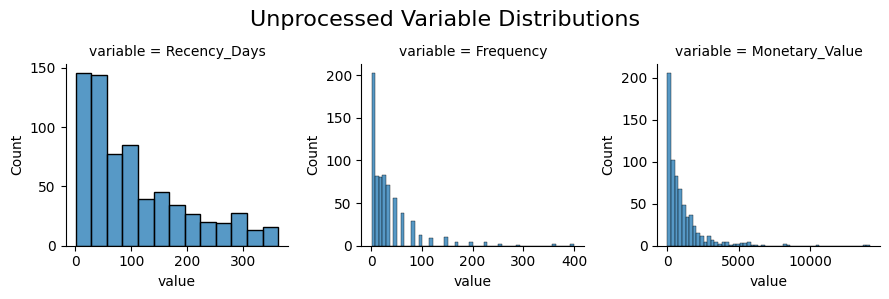

In [1739]:
# Plot the distributions of the selected variables
g = sns.FacetGrid(
    new_df_metrics.melt(),  # Reformat the DataFrame for plotting purposes
    col="variable",  # Split on the 'variable' column created by reformating
    sharey=False,  # Turn off shared y-axis
    sharex=False,  # Turn off shared x-axis
)
# Apply a histogram to the facet grid
g.map(sns.histplot, "value")
# Adjust the top of the plots to make room for the title
g.fig.subplots_adjust(top=0.8)
# Create a title
g.fig.suptitle("Unprocessed Variable Distributions", fontsize=16)
plt.show()

**Checking Numeric Data Types for Clustering**

Before moving forward with the K-means clustering process, it's essential to confirm that all selected columns for clustering are numeric. This step ensures the integrity of the data, as K-means requires numerical input for calculating distances between data points.

If the check returns True, we can confidently proceed with preprocessing the data for clustering.

In [1741]:
all([pd.api.types.is_numeric_dtype(new_df_metrics[col]) for col in columns_for_clustering])

True

### Manual Pre-processing
In this section, we perform a series of preprocessing steps essential for preparing our data for K-means clustering. These steps include centering, scaling, and applying transformations to ensure the data is suitable for analysis.

#### 1. Centering data manually
We start by centering the data, which involves subtracting the mean of each variable from the data points. This centers the data around zero, which can improve the performance of the clustering algorithm. 

In [1744]:
df_centered = new_df_metrics - new_df_metrics.mean()
df_centered.describe().round(2)

,Recency_Days,Frequency,Monetary_Value
count,693.00,693.00,693.00
mean,0.00,0.00,0.00
std,92.51,48.18,1463.91
min,-104.48,-32.37,-1056.84
25%,-70.48,-29.37,-853.63
50%,-29.48,-17.37,-453.12
75%,53.52,2.63,276.61
max,256.52,366.63,13145.25


#### 2. Scaling variables with different variance manually
Next, we scale the variables to account for differences in variance across the data. By dividing each variable by its standard deviation, we standardize the data, leading to a uniform scale.

In [1746]:
df_scaled = new_df_metrics / new_df_metrics.std()
df_scaled.describe().round(2)

,Recency_Days,Frequency,Monetary_Value
count,693.00,693.00,693.00
mean,1.14,0.69,0.72
std,1.00,1.00,1.00
min,0.01,0.02,0.00
25%,0.38,0.08,0.14
50%,0.82,0.33,0.41
75%,1.72,0.75,0.91
max,3.91,8.30,9.70


#### 3. Combining centering and scaling with StandardScaler()
To streamline our preprocessing, we can use StandardScaler from the sklearn.preprocessing library. This method automates the process of centering and scaling the data. After fitting the scaler to our data with scaler.fit(new_df_metrics), we apply the transformation to produce normalized data

In [1748]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(new_df_metrics)
df_normalized = scaler.transform(new_df_metrics)
print('mean: ', df_normalized.mean(axis=0).round(2))
print('std: ', df_normalized.std(axis=0).round(2))

mean:  [0. 0. 0.]
std:  [1. 1. 1.]


### Pre-processing Pipeline: Coding the Sequence
Based on our analysis of the variable distributions, we've identified a skew in the data that needs to be addressed before clustering. Here’s how we create a robust preprocessing pipeline:

#### 1. Log Transformation:
We apply a log transformation to the data to reduce skewness and make the distribution more normal. This is accomplished with df_log = np.log(new_df_metrics). Log transformation is particularly useful for handling positive skewness in monetary values and frequency counts.

#### 2. StandardScaler for Normalization:
After the log transformation, we use StandardScaler() again to fit and transform the log-transformed data. This step ensures our variables are centered and scaled appropriately, making them suitable for clustering.

#### 3. Storing and Visualizing the Results:
Finally, we store the normalized data in a new DataFrame, df_normalized, for further analysis. This DataFrame retains the original index and column names from new_df_metrics, allowing for easy reference during subsequent steps.

By implementing this comprehensive preprocessing pipeline, we ensure that our data is well-prepared for the K-means clustering algorithm, ultimately leading to more accurate and meaningful segmentation results.

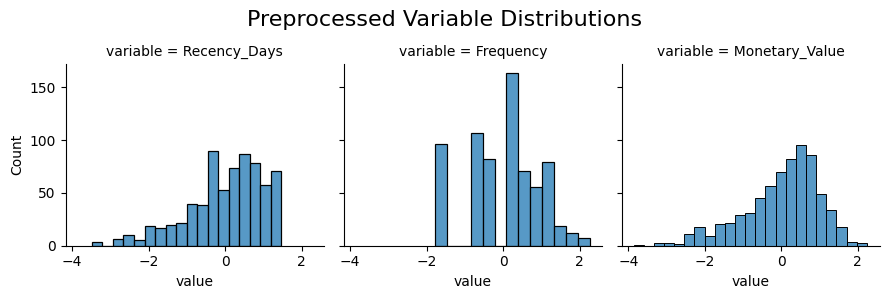

In [1750]:
# Unskew the data
import numpy as np
df_log = np.log(new_df_metrics)

# Normalize the variables
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(df_log)

# Store for clustering
df_normalized_ = scaler.transform(df_log)

# Create a pandas DataFrame
df_normalized = pd.DataFrame(data=df_normalized_, index=new_df_metrics.index, columns=new_df_metrics.columns)

# Plot the distributions of the selected variables
g = sns.FacetGrid(df_normalized.melt(), col="variable")
g.map(sns.histplot, "value")
g.fig.subplots_adjust(top=0.8)
g.fig.suptitle("Preprocessed Variable Distributions", fontsize=16)
plt.show()

## Step 5. Choosing the Number of Clusters: Elbow criterion method
The next phase involves fitting a range of cluster numbers and plotting the corresponding sum of squared errors (SSE) for each configuration. The SSE quantifies the total squared distances between each data point and its assigned cluster centroid. Our objective is to minimize the SSE while keeping the number of clusters manageable.

By visualizing the SSE against the number of clusters, we can pinpoint the threshold beyond which adding additional clusters yields diminishing returns. This visualization is commonly referred to as an elbow plot.

In the code provided below, you can specify the maximum number of clusters to evaluate. A loop iterates through this range to compute the SSE for each cluster count. Finally, the pointplot() function from Seaborn is employed to display a curve that represents the relationship between the number of clusters and their respective SSE values. This graphical representation enables the identification of the 'elbow' point, where further increases in cluster count result in only slight reductions in SSE.

C:\Users\vivia\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\vivia\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\vivia\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\vivia\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\vivia\anaconda3\Lib\site-packages\sklearn\clust

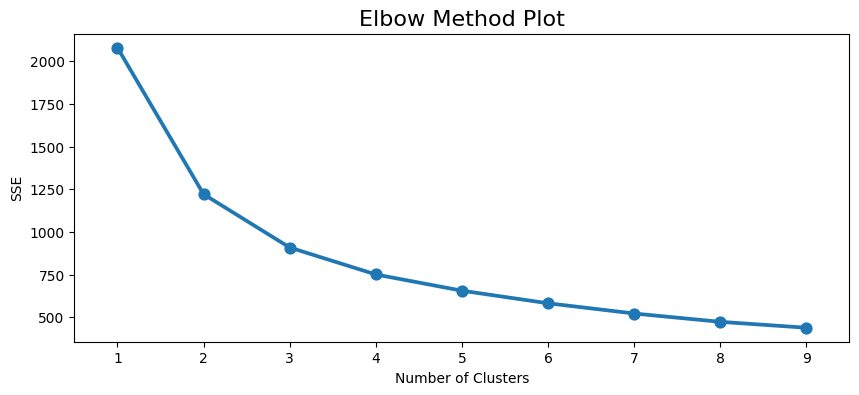

In [1752]:
# Set the maximum number of clusters to plot
max_clusters = 10

# Initialize empty dictionary to store sum of squared errors
sse = {}

# Fit KMeans and calculate SSE for each k
for k in range(1, max_clusters):
    # Initialize KMeans with k clusters
    kmeans = KMeans(n_clusters=k, random_state=1)
    # Fit KMeans on the normalized dataset
    kmeans.fit(df_normalized)
    # Assign sum of squared distances to k element of dictionary
    sse[k] = kmeans.inertia_

# Initialize a figure of set size
plt.figure(figsize=(10, 4))

# Create an elbow plot of SSE values for each key in the dictionary
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))

# Add labels to the plot
plt.title("Elbow Method Plot", fontsize=16)  # Add a title to the plot
plt.xlabel("Number of Clusters")  # Add x-axis label
plt.ylabel("SSE")  # Add y-axis label

# Show the plot
plt.show()

## Step 6. Experimenting with Clusters and Analyzing Segments
The elbow plot for our RFM data suggested two clusters, but it's worth experimenting with different numbers of clusters to see if we can uncover more detailed insights. Here, we explore segmentations using 2, 3, and 4 clusters, and then analyze the results.

While the two-cluster model provides a clear distinction between customer segments, the three-cluster model introduces more nuance by separating higher-value customers into different groups. Similarly, the four-cluster model breaks these distinctions down further, giving more insight into the distribution of customer behavior.

Ultimately, the decision on how many clusters to use depends on business needs and the analyst’s judgment. Let’s go through the outputs for each scenario and compare.

In [1754]:
df_normalized_

array([[ 0.90587847, -0.85095919, -0.1261132 ],
       [-0.21110606,  0.39217541, -0.51199522],
       [ 1.19201208, -1.7913542 , -2.19242217],
       ...,
       [-1.54727744,  0.84866838,  1.59994679],
       [-0.11398701,  1.02983085, -0.45106011],
       [-0.11398701, -1.7913542 , -1.30008261]])

### k=2
Here we start by using 2 clusters as suggested by the elbow method.

The result below clearly separates high-frequency, high-value customers (Cluster 0) from low-frequency, low-value customers (Cluster 1).

In [1756]:
# Import KMeans 
from sklearn.cluster import KMeans

# Initialize KMeans
kmeans = KMeans(n_clusters=2, random_state=1) 

# Fit k-means clustering on the normalized data set
kmeans.fit(df_normalized)

# Extract cluster labels
cluster_labels = kmeans.labels_

# Create a DataFrame by adding a new cluster label column
df_rfm_k2 = new_df_metrics.assign(Cluster=cluster_labels)

# Group the data by cluster
grouped = df_rfm_k2.assign(Cluster=cluster_labels).groupby(['Cluster'])

# Calculate average RFM values and segment sizes per cluster value
grouped.agg({
    'Recency_Days': 'mean',
    'Frequency': 'mean',
    'Monetary_Value': ['mean', 'count']
  }).round(1)

C:\Users\vivia\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Recency_Days Frequency Monetary_Value      
                mean      mean           mean count
Cluster                                            
0               81.2      50.0         1538.3   438
1              147.2       4.8          233.0   255

### k=3
Increasing the number of clusters to 3, we get more granularity.

In this scenario, the higher-value group is split into two clusters. Cluster 0 identifies the most recent and frequent buyers, while Cluster 1 captures a slightly less frequent, yet still valuable, group. Cluster 2 still reflects the low-frequency, low-value segment.

In [1758]:
# Import KMeans 
from sklearn.cluster import KMeans

# Initialize KMeans
kmeans = KMeans(n_clusters=3, random_state=1) 

# Fit k-means clustering on the normalized data set
kmeans.fit(df_normalized)

# Extract cluster labels
cluster_labels = kmeans.labels_

# Create a DataFrame by adding a new cluster label column
df_rfm_k3 = new_df_metrics.assign(Cluster=cluster_labels)

# Group the data by cluster
grouped = df_rfm_k3.assign(Cluster=cluster_labels).groupby(['Cluster'])

# Calculate average RFM values and segment sizes per cluster value
grouped.agg({
    'Recency_Days': 'mean',
    'Frequency': 'mean',
    'Monetary_Value': ['mean', 'count']
  }).round(1)

C:\Users\vivia\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Recency_Days Frequency Monetary_Value      
                mean      mean           mean count
Cluster                                            
0               12.7      50.4         1377.6   133
1              112.8      45.9         1509.1   337
2              149.8       4.2          185.7   223

### k=4
Adding a fourth cluster provides even more detail.

This further breaks down the customers, clearly identifying a high-value, frequent shopper group (Cluster 0) and splitting the low-value group into those who shop infrequently but occasionally make large purchases (Cluster 3) and those who rarely shop at all (Cluster 1).

Through this experimental approach, you can select the segmentation that best aligns with your business objectives.

In [1760]:
# Import KMeans 
from sklearn.cluster import KMeans

# Initialize KMeans
kmeans = KMeans(n_clusters=4, random_state=1) 

# Fit k-means clustering on the normalized data set
kmeans.fit(df_normalized_)

# Extract cluster labels
cluster_labels = kmeans.labels_

# Create a DataFrame by adding a new cluster label column
df_rfm_k4 = new_df_metrics.assign(Cluster=cluster_labels)

# Group the data by cluster
grouped = df_rfm_k4.assign(Cluster=cluster_labels).groupby(['Cluster'])

# Calculate average RFM values and segment sizes per cluster value
grouped.agg({
    'Recency_Days': 'mean',
    'Frequency': 'mean',
    'Monetary_Value': ['mean', 'count']
  }).round(1)

C:\Users\vivia\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Recency_Days Frequency Monetary_Value      
                mean      mean           mean count
Cluster                                            
0               95.5      60.0         1850.8   242
1              148.4       2.4           62.8   122
2               11.6      50.1         1369.5   121
3              146.5      10.8          538.3   208

## Step 7. Clustering the Data
After careful analysis and evaluation, we have decided to move forward with a k=4 cluster segmentation for this project. This decision was driven by the desire to achieve a more nuanced understanding of our customer base, allowing for targeted strategies that maximize business impact. The four-cluster solution provides greater insight into key customer behaviors, including high-value frequent shoppers, moderate-value frequent buyers, and low-frequency segments. This granularity enables us to craft personalized marketing campaigns that resonate with each distinct group, optimizing engagement and resource allocation across our customer base.

From a data-driven perspective, this decision aligns with the business's goal to optimize resource allocation and tailor retention strategies to each unique customer group. The additional segmentation also opens the door for more focused product and service development, helping the company prioritize features and offers that resonate with its most valuable segments. For data analytics professionals, this decision demonstrates a commitment to leveraging advanced clustering techniques to enhance decision-making and drive business outcomes. The use of k=4 provides a balance between actionable insights and manageable complexity, ensuring that the segmentation strategy adds meaningful value to both the business and its customers.
### Clustering with KMeans (k=4)
After selecting k=4 clusters based on the elbow method and the analysis of segment patterns, we initialize the KMeans algorithm and apply it to our normalized dataset. By setting n_clusters=4, we instruct the model to group the data into four distinct clusters.

* **Fitting the Model:** We fit the KMeans model to the normalized data using .fit(). This step organizes the data points into clusters by minimizing the distance between each data point and its assigned cluster center.

* **Assigning Cluster Labels:** Once the clustering is complete, the labels_ attribute from the KMeans object is extracted. These labels represent which cluster each data point belongs to.

* **Adding Cluster Information:** A new DataFrame is created where we append these cluster labels to the original dataset, allowing us to associate each customer with one of the four clusters.

The result is a DataFrame that displays each customer’s Recency, Frequency, and Monetary Value (RFM), along with their corresponding cluster assignment. This allows us to analyze and interpret the characteristics of each segment more effectively.

In [1762]:
# Choose number of clusters
k = 4

# Initialize KMeans
kmeans = KMeans(n_clusters=k, random_state=1) 

# Fit k-means clustering on the normalized data set
kmeans.fit(df_normalized)

# Extract cluster labels
cluster_labels = kmeans.labels_

# Create a new DataFrame by adding a new cluster column to the original data
df_clustered = df_grouped.assign(Cluster=cluster_labels)

# Preview the clustered DataFrame
df_clustered

C:\Users\vivia\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,Customer ID,Recency_Days,Frequency,Monetary_Value,Cluster
0,AA-10315,185,2.0,374.480,3
1,AA-10375,49,5.0,206.732,3
2,AA-10480,260,1.0,15.552,1
3,AA-10645,234,1.0,12.960,1
4,AB-10060,106,8.0,2936.264,0
...,...,...,...,...,...
688,XP-21865,44,6.0,449.312,0
689,YC-21895,5,1.0,750.680,2
690,YS-21880,10,7.0,5340.264,2
691,ZC-21910,55,8.0,227.066,0


## Step 8. Inspecting the Clutsers

### Analyzing Cluster Composition
The next step is to analyze the unprocessed data by cluster. The pandas method DataFrame.groupby(), combined with the .size() method, r reveals the total number of customers in each cluster, indicating how the data is distributed among the four segments. This information is crucial for understanding the relative importance of each cluster in terms of customer base.

In [1765]:
# Group the data by cluster and calculate the total number of rows per group
df_sizes = df_clustered.groupby(["Cluster"], as_index=False).size()

# Inspect the row counts
df_sizes

,Cluster,size
0,0,242
1,1,122
2,2,121
3,3,208


### Visualizing Cluster Characteristics
Next, the mean values per cluster are visualized. The data is grouped again, and this time, the pandas method .mean() is used to aggregate the data by cluster and calculate the mean for each variable. Alternatively, the .agg() method can also be used to specify specific aggregations for different columns if necessary. 

The seaborn catplot() function visualizes the means per cluster. The resulting visualization highlights the differences between clusters, making it easy to identify patterns and trends in customer behavior.

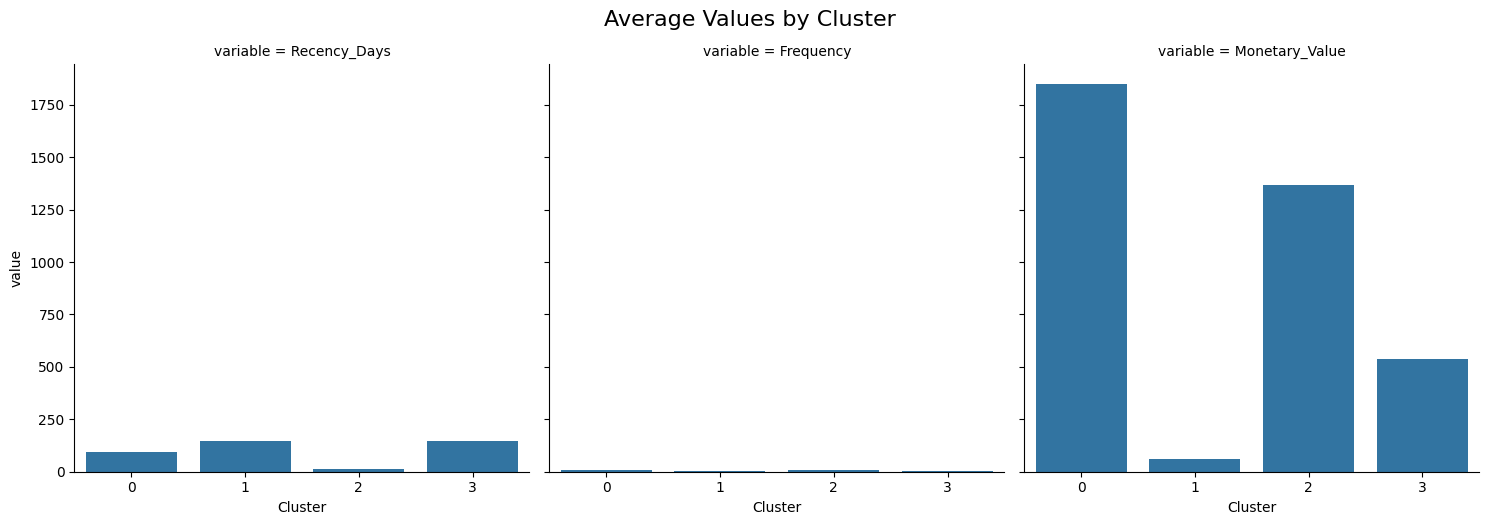

In [1767]:
# Calculate the mean of feature columns by cluster
df_means = df_clustered.groupby(["Cluster"])[df_features.columns].mean().reset_index()

# Plot the distributions of the selected variables
sns.catplot(
    data=df_means.melt(id_vars="Cluster"),  # Transform the data to enable plotting
    col="variable",
    x="Cluster",
    y="value",
    kind="bar",
)

# Add a title
plt.suptitle("Average Values by Cluster", y=1.04, fontsize=16)

# Show the plot
plt.show()

In [1768]:
df_means

,Cluster,Recency_Days,Frequency,Monetary_Value
0,0,95.512397,7.181818,1850.780565
1,1,148.360656,1.409836,62.762164
2,2,11.586777,6.330579,1369.493918
3,3,146.538462,3.057692,538.272165


### Cluster Insights
#### Cluster 0
This cluster has a relatively low recency score, indicating that these customers have engaged with the business fairly recently. The high frequency of purchases suggests they are frequent buyers and exhibit significant spending behavior. This segment represents a valuable group of loyal customers who may benefit from targeted retention strategies or loyalty programs to encourage continued engagement.
#### Cluster 1
Customers in this cluster have a high recency value, implying they have not engaged with the business for some time. Their low frequency of purchases and minimal monetary value indicate they may be at risk of churning. This cluster could benefit from re-engagement campaigns, such as personalized offers or promotions to reignite interest and drive purchases.
#### Cluster 2
This cluster has the lowest recency score, suggesting these customers are very recent buyers. They have a moderate frequency of purchases and a respectable monetary value, indicating they are active but may not yet be considered loyal. This segment may be a target for upselling or cross-selling strategies, as they have demonstrated initial interest and engagement.
#### Cluster 3
Customers in this cluster also have high recency and lower frequency and monetary values, similar to Cluster 1. This indicates potential disengagement and a need for targeted efforts to rekindle interest. Engaging this group with personalized communication or incentives could help improve their purchasing behavior.

**Overall Deduction**

By analyzing the mean values across the clusters, we can see a distinct pattern in customer behavior. Clusters 0 and 2 represent more engaged and potentially high-value segments, while Clusters 1 and 3 indicate a need for strategic interventions to improve engagement and retention.

Tailored marketing efforts can be developed based on these insights, allowing for a more effective allocation of resources and ultimately leading to improved customer relationships and increased profitability.

### Create a Snake Plot of the Clusters
In this step, we visualize the differences between the customer segments using a snake plot, which effectively highlights trends and key distinctions among the clusters. The code leverages the following methods:

* DataFrame.assign(): This function adds the cluster labels to the normalized data, associating each observation with its respective cluster.
* DataFrame.melt(): The data is transformed from a wide format to a long format, facilitating easier plotting by creating two new columns: one for the metric names and another for their corresponding values.
* Seaborn lineplot(): This function generates the snake plot, with distinct lines representing each cluster, allowing for a clear comparison of average normalized values across different metrics.

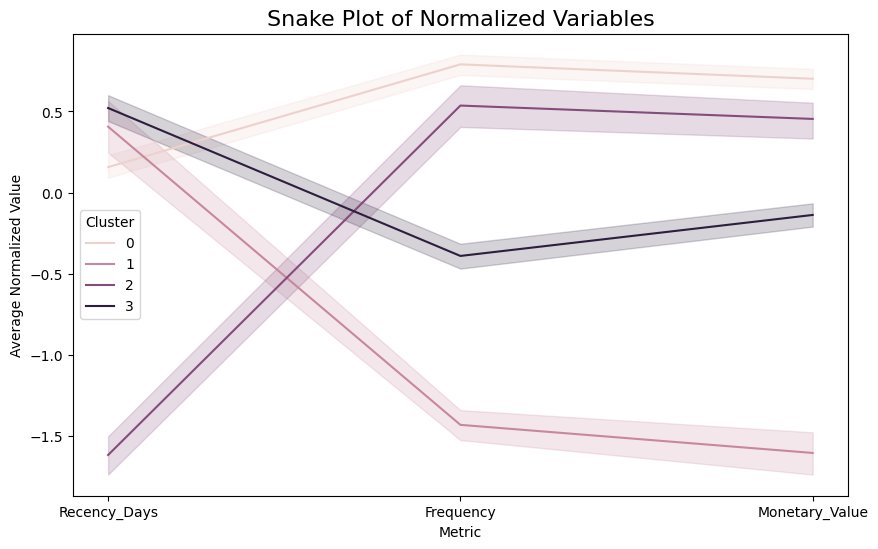

In [1771]:
# Assign cluster labels to processed DataFrame
df_processed_clustered = df_normalized.assign(Cluster=cluster_labels)

# Melt the normalized DataFrame and reset the index
df_processed_melt = pd.melt(
    df_processed_clustered.reset_index(),
    # Assign the cluster labelss as the ID
    id_vars=['Cluster'],
    # Assign clustering variables as values
    value_vars=df_features.columns,
    # Name the variable and value
    var_name="Metric",
    value_name="Value",
)

# Change the figure size
plt.figure(figsize=(10, 6))

# Add label and titles to the plot
plt.title('Snake Plot of Normalized Variables', fontsize=16)
plt.xlabel('Metric')
plt.ylabel('Average Normalized Value')

# Plot a line for each value of the cluster variable
sns.lineplot(data=df_processed_melt, x='Metric', y='Value', hue='Cluster')
plt.show()

### Create a Heatmap of Relative Importances
In this step, we utilize a heatmap to visualize the distinctiveness of each customer segment based on their average feature values. The process is as follows:

* Calculate Average Values: We first compute the average values for each feature within each cluster.
* Population Averages: We then calculate the overall average values for the entire customer population.
* Relative Importance Calculation: By dividing the cluster averages by the population averages and subtracting one, we derive a relative importance score for each feature.

The resulting scores indicate how much each feature's average value for a cluster deviates from the overall population average. The Seaborn heatmap() function plots these scores on a color scale ranging from red to blue, providing a clear visual representation of each feature's significance within the segments. This heatmap serves as a powerful tool for understanding the relative strengths and weaknesses of the clusters, guiding strategic decisions in customer engagement and marketing efforts.

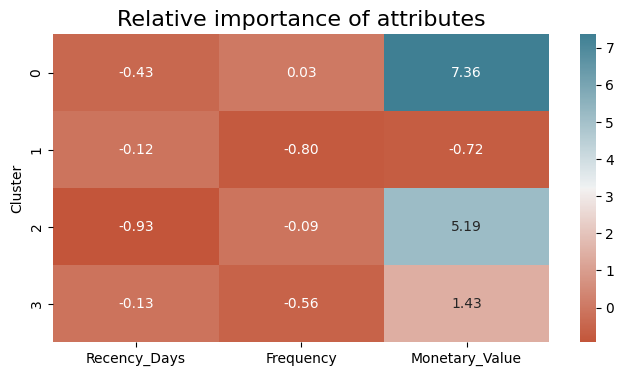

In [1773]:
# Calculate average RFM values for each cluster
cluster_avg = df_clustered.groupby(["Cluster"])[columns_for_clustering].mean()

# Calculate average RFM values for the total customer population
population_avg = df[columns_for_clustering].mean()

# Calculate relative importance of cluster's attribute value compared to population
relative_imp = cluster_avg / population_avg - 1

# Change the figure size
plt.figure(figsize=(8, 4))

# Add the plot title
plt.title("Relative importance of attributes", fontsize=16)

# Plot the heatmap
sns.heatmap(data=relative_imp, annot=True, fmt=".2f", cmap=sns.diverging_palette(20, 220, as_cmap=True))
plt.show()

In [1774]:
print(relative_imp)

         Recency_Days  Frequency  Monetary_Value
Cluster                                         
0           -0.431535   0.028547        7.360144
1           -0.116996  -0.798090       -0.716498
2           -0.931039  -0.093363        5.186129
3           -0.127841  -0.562091        1.431424


### Heatmap Insights
#### Cluster 0
This group demonstrates the most favorable profile, with a substantial positive score for Monetary Value (7.36), indicating that this segment has the highest spending capacity relative to the overall customer base. However, they exhibit higher recency (−0.43), suggesting they may not have engaged recently, which poses an opportunity for re-engagement strategies.
#### Cluster 1
This group shows negative scores across all metrics, particularly a notable decrease in Frequency (−0.80) and Monetary Value (−0.72). This cluster represents customers who not only purchase infrequently but also contribute less to overall revenue, signaling the need for targeted campaigns to improve retention and increase their engagement levels.
#### Cluster 2
This cluster stands out with a high negative recency score (−0.93), indicating that this segment has the longest time since their last purchase. However, it also shows a moderate positive score for Monetary Value (5.19), suggesting these customers can generate substantial revenue if reactivated. Their relatively stable frequency indicates potential for increasing engagement through strategic marketing initiatives.
#### Cluster 3
This cluster presents a mixed profile with moderate negative scores for Frequency (−0.56) and a positive Monetary Value (1.43). This suggests that while this group has some purchasing power, their frequency of transactions could be improved. This cluster may benefit from loyalty programs or incentives to encourage repeat purchases.

**Overall Deduction**

In summary, the heatmap not only highlights the varying dynamics across clusters but also underscores strategic opportunities for customer relationship management. By leveraging these insights, we can tailor marketing efforts to enhance customer engagement, ultimately driving sales and improving retention across segments. This nuanced understanding positions our organization to make data-informed decisions that align with overall business objectives.

# Conclusion
Thank you for taking the time to explore my Customer Segmentation Report! I hope you found the insights and methodologies outlined in this project both informative and valuable.